In [1]:
from image_objects import AllImages
from typing import List
import os
import cv2

In [2]:
import pydantic
pydantic.__version__

'2.11.4'

In [3]:
def get_all_images_objects():
    all_images = AllImages()
    repo_path = "/notebooks/DL---detection-of-birds-in-drone-images"
    test_images = all_images.get_files_in_data_folder(f"{repo_path}/data/Harmful Birds Detection.v1i.yolov11/test")
    train_images = all_images.get_files_in_data_folder(f"{repo_path}/data/Harmful Birds Detection.v1i.yolov11/train")
    valid_images = all_images.get_files_in_data_folder(f"{repo_path}/data/Harmful Birds Detection.v1i.yolov11/valid")
    all_images.load_removed_background_pictures(f"{repo_path}/data/Subject images crows/Subjects not pixelated")
    return all_images

all_images_objects = get_all_images_objects()


# Augment all the data

Below is the function that iterates over all the images in the given folder. 
For each image a random cropped image is then taken to be squeeze and cropped onto the image in the folder

In [19]:
from IPython.display import Image
import numpy as np
import random

def get_average_bounding_box(label_path: str):
    """label_path is the location to the yoloflow.txt file of the image. takes all the bounding boxes of the image and calculate the average"""
    with open(label_path) as f:
        bounding_boxes = f.readlines()
        
    bounding_boxes = [bounding_box.strip().split(" ") for bounding_box in bounding_boxes]
    #bird_class, x_center_rel, y_center_rel, width_rel, height_rel = map(float, largest_bounding_box.split(" "))
    average_rel_width = sum([float(bounding_box[3]) for bounding_box in bounding_boxes])/len(bounding_boxes)
    average_rel_height = sum([float(bounding_box[4]) for bounding_box in bounding_boxes])/len(bounding_boxes)

    return (average_rel_width, average_rel_height)

def add_picture_to_picture(file_name: str, folder_path: str, average_rel_width, average_rel_height):
    """file_name is the name of the file to be augmented onto
    folder_path is where the filename is in
    average_rel_width and average_rel_height should come from the function get_average_bounding_box(label_path)
    """
    image_path = f"{folder_path}/images/{file_name}.png"
    label_path = f"{folder_path}/labels/{file_name}.txt"
        
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    h, w, channels = img.shape
    height_pixels = int(h*average_rel_height)
    width_pixels = int(w*average_rel_width)
        
    cropped_pil = all_images_objects.get_random_cropped_images(width_pixels)
    
    # Convert PIL to OpenCV format
    cropped_np = np.array(cropped_pil)
    cropped_cv = cv2.cvtColor(cropped_np, cv2.COLOR_RGBA2BGRA)  # Preserve alpha channel
    print(random.randint(3+int(width_pixels*0.5), w-3-int(width_pixels*0.5)))
    # Choose a position to paste. At least 3 pixels from the border and half of the picture size to be added
    x_offset, y_offset = random.randint(3+int(width_pixels*0.5), w-3-int(width_pixels*0.5)), random.randint(3+height_pixels*0.5,h-3-height_pixels*0.5)
    
    # Get overlay dimensions
    overlay_h, overlay_w = cropped_cv.shape[:2]
    
    # Make sure the overlay fits within the image bounds
    if y_offset + overlay_h > h:
        overlay_h = h - y_offset
        cropped_cv = cropped_cv[:overlay_h, :, :]
    
    if x_offset + overlay_w > w:
        overlay_w = w - x_offset
        cropped_cv = cropped_cv[:, :overlay_w, :]
    
    # Get the ROI from the original image
    roi = img[y_offset:y_offset+overlay_h, x_offset:x_offset+overlay_w]
    
    # Check channels
    ch = cropped_cv.shape[2]

    # Proper alpha blending
    if ch == 4:  # If we have an alpha channel
        # Extract the alpha channel and normalize to [0, 1]
        alpha = cropped_cv[:, :, 3] / 255.0
        
        # Create a 3-channel alpha mask
        alpha_3d = np.dstack((alpha, alpha, alpha))
        
        # Extract BGR channels from overlay
        overlay_bgr = cropped_cv[:, :, :3]
        
        # Calculate blended image
        blended = (1.0 - alpha_3d) * roi + alpha_3d * overlay_bgr
        
        # Replace the ROI with the blended image
        img[y_offset:y_offset+overlay_h, x_offset:x_offset+overlay_w] = blended.astype(np.uint8)
    else:
        # Just copy if no alpha
        img[y_offset:y_offset+overlay_h, x_offset:x_offset+overlay_w] = cropped_cv
    
    # below we are adding the newly generated image that is augmented with one extra bird
    # we add the label as well to the dataset
    x_offset_rel = x_offset/w
    y_offset_rel = y_offset/h
    x_rel = overlay_w/w
    y_rel = overlay_h/h
    new_yolo_label_str = f"0 {x_offset_rel+0.5*x_rel} {y_offset_rel+0.5*y_rel} {x_rel} {y_rel}"
    with open(label_path, "a") as f:
        f.write(f"\n{yolo_label_str}")
    cv2.imwrite(image_path, img)

In [2]:
from augment_pictures import get_average_bounding_box, add_picture_to_picture, all_images_objects



Columba-livia370_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia370_jpg.rf Background Removed.820af8710adf35456fd92c3b3098ee28.png


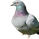

3797


In [3]:
repo_path = "/notebooks/DL---detection-of-birds-in-drone-images"

yolo_path = f"{repo_path}/data/data_yolo_format"
file_name = "20240901115456_0265_D_frame_1230 - kopie.txt"
average_rel_width, average_rel_height = get_average_bounding_box(f"{yolo_path}/train/labels/{file_name}")
add_picture_to_picture("20240901115456_0265_D_frame_1230 - kopie", f"{yolo_path}/train", average_rel_width, average_rel_height)

In [10]:
all_images_objects.get_random_instance((0,))

ImageData(image_name='NKO87PXI1GEM_jpg', image_paths=['/notebooks/DL---detection-of-birds-in-drone-images/data/Harmful Birds Detection.v1i.yolov11/test/images/NKO87PXI1GEM_jpg.rf.6d5c9ae7082739a7dc0cb0d72778ffe2.jpg', '/notebooks/DL---detection-of-birds-in-drone-images/data/Harmful Birds Detection.v1i.yolov11/test/images/NKO87PXI1GEM_jpg.rf.9cb098960629b77a8884fdc1809fe96c.jpg', '/notebooks/DL---detection-of-birds-in-drone-images/data/Harmful Birds Detection.v1i.yolov11/test/images/NKO87PXI1GEM_jpg.rf.53d88a8a7ff0747ab4e055328964f8b9.jpg'], label_text='0 0.53359375 0.47265625 0.9328125 0.55625', bird_class=0, cleaned_file='/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/NKO87PXI1GEM_jpg.rf Background Removed.9cb098960629b77a8884fdc1809fe96c.png')

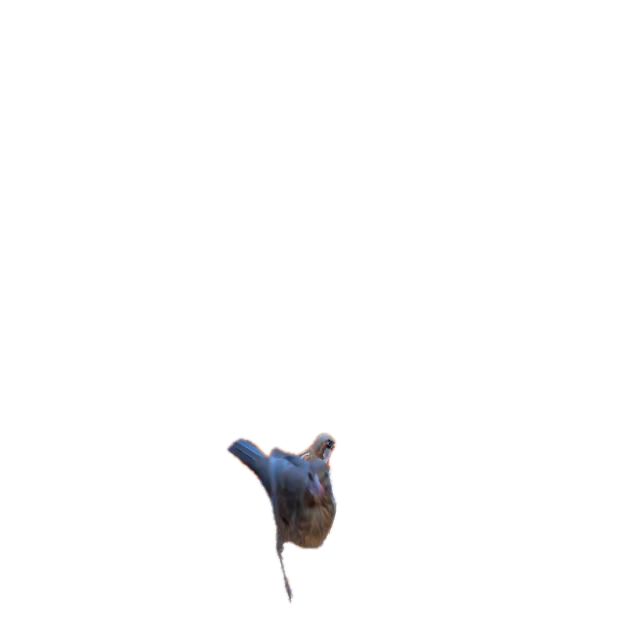

In [14]:
all_images_objects.images_dict["vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-10_jpg"].get_cleaned_image()

the opacity is too little for the largest bounding box


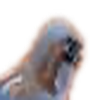

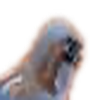

In [10]:
all_images_objects.images_dict["vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-10_jpg"].get_cropped_images(100)

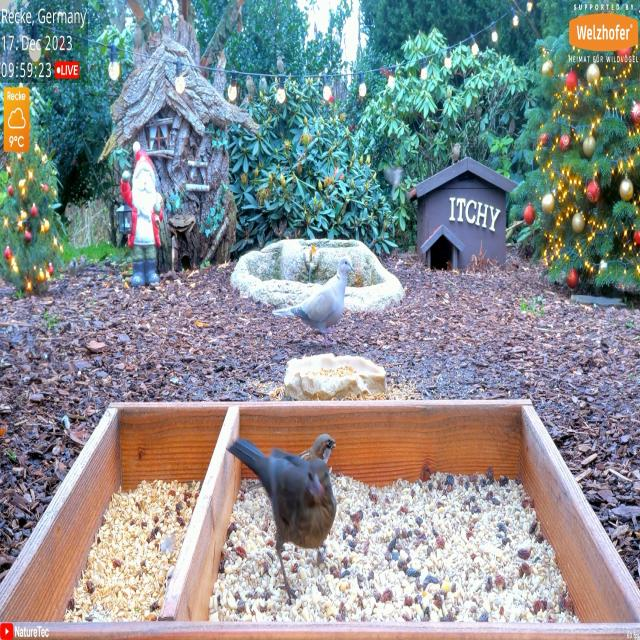

In [51]:
from IPython.display import Image, display

display(Image(all_images_objects.images_dict["vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-10_jpg"].get_random_image_path()[1]))